## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import acquire
import prepare

In [2]:
df = pd.read_csv('saas.csv')
df.columns = [col.lower() for col in df.columns]

In [3]:
df.index = pd.to_datetime(df.month_invoiced)
df = df.drop(columns=['month_invoiced'])

In [4]:
df.head()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [5]:
# split into train, validation, test
train = df.loc[:'2016-01-31']
validate = df.loc['2016-01-31':'2017-01-31']
test = df.loc['2017-01-31': ]

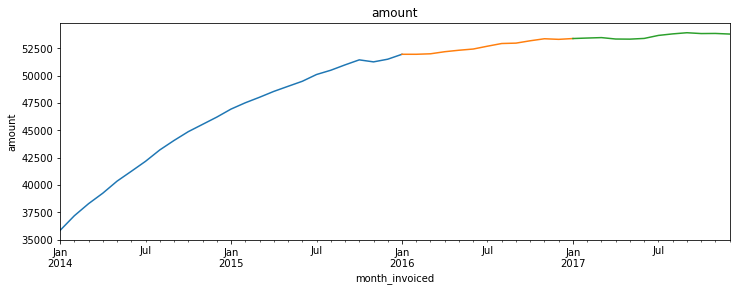

In [6]:
col = 'amount'
resample_by = 'M'
plt.figure(figsize=(12,4))
train.resample(resample_by).sum().amount.plot()
validate.resample(resample_by).sum().amount.plot()
test.resample(resample_by).sum().amount.plot()
plt.ylabel(col)
plt.title(col)
plt.show()

In [7]:
train = train.resample('M').sum()
validate = validate.resample('M').sum()
test = test.resample('M').sum()

In [8]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'Predicted')
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Last observed Value

In [9]:
amount = train.resample('M').amount.sum()[-1:][0]

yhat_df = pd.DataFrame({'amount': [amount]}, 
                       index = validate.index)

yhat_df.head(2)

,amount
month_invoiced,
2016-01-31,51955.0
2016-02-29,51955.0


amount -- RMSE: 897


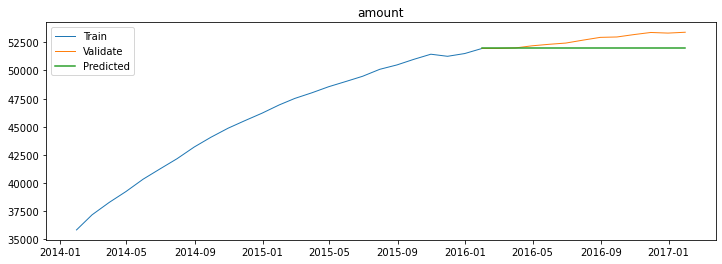

In [10]:
plot_and_eval('amount')

In [11]:
eval_df = append_eval_df(model_type='last_observed_value', target_var = 'amount')

In [12]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,897.0


In [13]:
amount = train.resample('M').amount.sum().mean()

yhat_df = pd.DataFrame({'amount': [amount]}, 
                       index = validate.index)

yhat_df.head(2)

,amount
month_invoiced,
2016-01-31,45824.0
2016-02-29,45824.0


amount -- RMSE: 6870


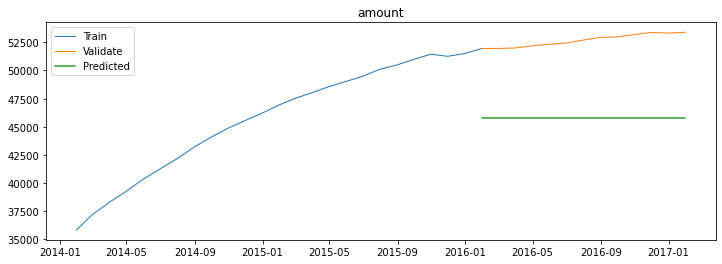

In [14]:
plot_and_eval('amount')

### Simple Average

In [15]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [16]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,897.0
1,simple_average,amount,6870.0


### 10M Moving avg

In [17]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 10

amount = round(train.resample('M').amount.sum().rolling(period).mean().iloc[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'amount': [amount],
                           }, index = validate.index)
yhat_df.head(2)

,amount
month_invoiced,
2016-01-31,50482.0
2016-02-29,50482.0


amount -- RMSE: 2256


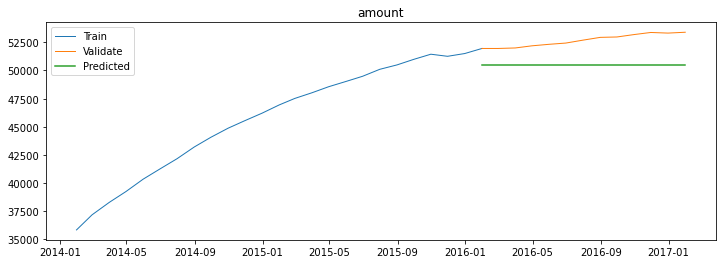

In [18]:
plot_and_eval('amount')

In [19]:
append_eval_df(model_type='10M moving average',target_var='amount')

,model_type,target_var,rmse
0,last_observed_value,amount,897.0
1,simple_average,amount,6870.0
2,10M moving average,amount,2256.0


In [20]:
periods = range(1,12)

for p in periods:
    

    amount = round(train.resample('M').amount.sum().rolling(p).mean().iloc[-1], 2)

    # yhat_df = make_predictions()

    yhat_df = pd.DataFrame({'amount': [amount],
                               }, index = validate.index)

    model_type = str(p) + 'M moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'amount'
                            )

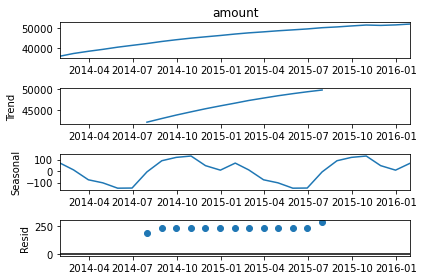

In [21]:
sm.tsa.seasonal_decompose(train.amount).plot()
None

### Holt's Linear Trend Model

In [22]:
model = Holt(train.amount, exponential = False, damped=True)
model = model.fit(optimized = True)
yhat_items = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['amount'] = round(yhat_items, 2)

amount -- RMSE: 868


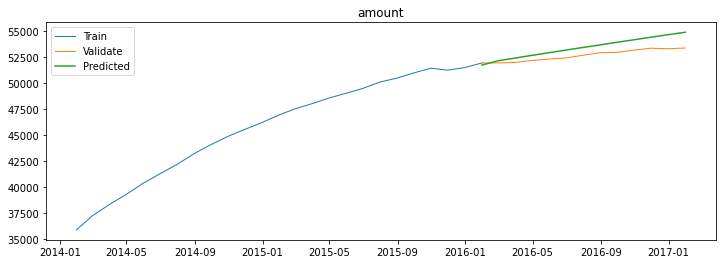

In [23]:
plot_and_eval('amount')

In [24]:
eval_df=append_eval_df(model_type='Holts', target_var='amount')

In [25]:
train_h = train
validate_h = validate
test_h = test

### Previous Cycle

In [26]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [27]:
train = train.resample('M').sum()
validate = validate.resample('M').sum()
test = test.resample('M').sum()

In [28]:
yhat_df = train['2015'] + train.diff(12).mean()

In [29]:
yhat_df

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2015-01-31,1.610465e+10,8.715585e+10,11006.75,55033.75
2015-02-28,1.595642e+10,8.668951e+10,11121.75,55608.75
2015-03-31,1.580715e+10,8.621000e+10,11222.75,56113.75
2015-04-30,1.565336e+10,8.570140e+10,11329.75,56648.75
2015-05-31,1.550303e+10,8.520072e+10,11422.75,57113.75
2015-06-30,1.536759e+10,8.477223e+10,11514.75,57573.75
2015-07-31,1.523028e+10,8.432606e+10,11638.75,58193.75
2015-08-31,1.509680e+10,8.389434e+10,11716.75,58583.75
2015-09-30,1.495113e+10,8.339126e+10,11814.75,59073.75


In [30]:
pd.concat([yhat_df.head(1), validate.head(1)])

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2015-01-31,1.610465e+10,8.715585e+10,11006.75,55033.75
2016-01-31,1.635248e+10,8.781191e+10,10391.00,51955.00


In [31]:
yhat_df.index = validate.index

In [32]:
yhat_df = pd.DataFrame(yhat_df)

amount -- RMSE: 5192


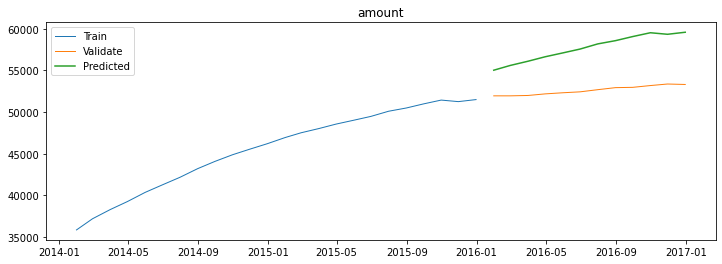

In [33]:
plot_and_eval('amount')
eval_df = append_eval_df(model_type='previous_year', target_var='amount')

In [34]:
# get the min rmse for each variable

min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_amount)
        )]

,model_type,target_var,rmse
13,Holts,amount,868.0


### Based on previous year/month/etc., this is up to you.

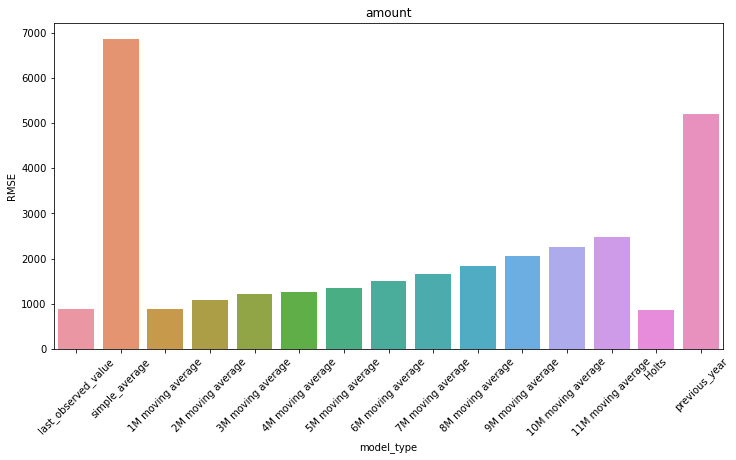

In [35]:
x = eval_df[eval_df.target_var == 'amount']['model_type']
y = eval_df[eval_df.target_var == 'amount']['rmse']
plt.figure(figsize=(12, 6))
sns.barplot(x, y)
plt.title(col)
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

### Predict using Holts on Test

In [36]:
model = Holt(train_h.amount, exponential = False, damped=True)
model = model.fit(optimized = True)
yhat_items = model.predict(start = validate_h.index[0], 
                           end = validate_h.index[-1])
yhat_df['amount'] = round(yhat_items, 2)

In [37]:
yhat_test = model.predict(start = test.index[0],
                          end = test.index[-1])

In [38]:
yhat_test_df = pd.DataFrame(yhat_test, columns = ['amount'])

TEST SET amount -- RMSE: 2642


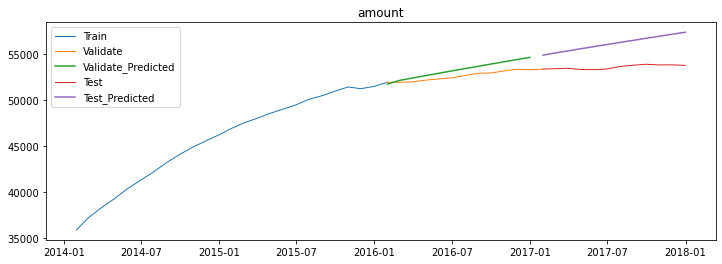

In [39]:
target_var = 'amount'
plt.figure(figsize = (12,4))
plt.plot(train_h[target_var], label = 'Train', linewidth = 1)
plt.plot(validate_h[target_var], label = 'Validate', linewidth = 1)
plt.plot(yhat_df[target_var], label = 'Validate_Predicted')
plt.plot(test_h[target_var], label = 'Test', linewidth = 1)
plt.plot(yhat_test_df[target_var], label = 'Test_Predicted')
plt.title(target_var)
plt.legend()
rmse = mean_squared_error(test_h[target_var],yhat_test_df[target_var], squared=False)
print('TEST SET',target_var, '-- RMSE: {:.0f}'.format(rmse))
plt.show()

### Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.

In [40]:
from sklearn import svm
from sklearn import metrics

In [41]:
store = acquire.acquire_all()
store = prepare.prepare_store(store)

In [43]:
daily_df = store.quantity.resample('D').agg('mean')

In [44]:
train = np.array(daily_df[:'2016'])
test = np.array(daily_df['2017':])

In [45]:
def embed_data(x, steps):
    n = len(x)
    xout = np.zeros((n-steps, steps))
    yout = x[steps:]
    for i in np.arange(steps, n):
        xout[i-steps] = x[i-steps:i]
    return xout, yout


In [46]:
xtrain, ytrain = embed_data(train, 50)

In [47]:
xtest, ytest = embed_data(test, 50)

In [48]:
m = svm.SVR(gamma = 0.1)
m_fit = m.fit(xtrain,ytrain)

In [49]:
y_pred = m_fit.predict(xtrain)

In [50]:
mse = metrics.mean_squared_error(y_pred, ytrain, squared=False)

In [51]:
print(mse)

11.042692098498623


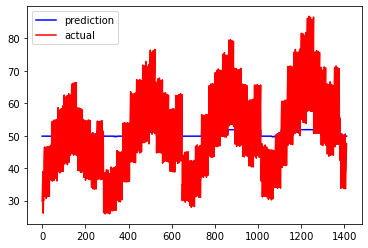

In [52]:
plt.plot(y_pred, 'b-', label = 'prediction')
plt.plot(ytrain, 'r-', label = 'actual')
plt.legend()

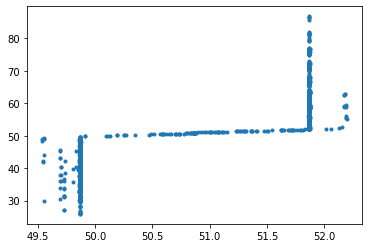

In [53]:
plt.plot(y_pred, ytrain, '.')

In [54]:
y_test_pred = m_fit.predict(xtest)

In [55]:
metrics.mean_squared_error(y_test_pred, ytest, squared=False)

15.839347691215357

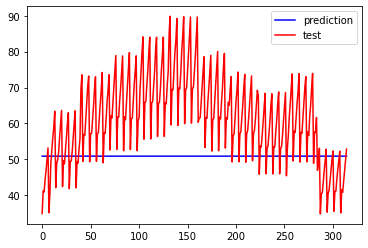

In [56]:
plt.plot(y_test_pred,'b-', label = 'prediction')
plt.plot(ytest, 'r-', label = 'test')
plt.legend()